In [1]:
import sys
sys.path.append('../utils')


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from payoff import payoff_func

Hello
Worst performance: 0.9580402619451855
Barrier event reached: True
Close above initial: 1
Final payoff: 1045.5402619451856


In [3]:
# List of tickers
tickers = ['rog', 'cfr', 'zurn']

# Date range for filtering
start_date = '2023-10-25'
end_date = '2024-10-24'

# Function to read and filter CSV files
def read_and_filter_csv(file_path, date_col='Date', price_col='Last Price'):
    df = pd.read_csv(file_path)
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    return df[(df[date_col] >= start_date) & (df[date_col] <= end_date)]

# Initialize the combined DataFrame
combined_df = pd.DataFrame()

# Process tickers for prices and implied volatility
for t in tickers:
    # Read and filter price data
    price_df = read_and_filter_csv(f'../data/{t}.csv')
    price_df = price_df[['Date', 'Last Price']].rename(columns={'Last Price': f'{t.upper()}_Last_Price'})
    
    # Read and filter implied volatility data
    ivol_df = read_and_filter_csv(f'../data/{t}_ivol.csv', price_col='IVOL')
    ivol_column_name = ivol_df.columns[1]
    ivol_df = ivol_df[['Date', ivol_column_name]].rename(columns={ivol_column_name: f'{t.upper()}_IVOL'})

    # Merge the dataframes
    combined_df = pd.merge(combined_df, price_df, on='Date', how='outer') if not combined_df.empty else price_df
    combined_df = pd.merge(combined_df, ivol_df, on='Date', how='outer')

# Read and filter risk-free rate data
risk_free_df = read_and_filter_csv('../data/risk_free.csv')
risk_free_column_name = risk_free_df.columns[1]
risk_free_df = risk_free_df[['Date', risk_free_column_name]].rename(columns={risk_free_column_name: 'Risk_Free_Rate'})

# Merge risk-free rate data
combined_df = pd.merge(combined_df, risk_free_df, on='Date', how='outer')

# Sort and reset index
combined_df = combined_df.sort_values('Date').reset_index(drop=True)

# Show the combined DataFrame
combined_df

,Date,ROG_Last_Price,ROG_IVOL,CFR_Last_Price,CFR_IVOL,ZURN_Last_Price,ZURN_IVOL,Risk_Free_Rate
0,2023-10-25,237.55,17.6858,107.00,33.0793,426.4,15.7900,1.4594
1,2023-10-26,237.25,17.9504,104.45,33.5406,426.8,15.9736,1.4508
2,2023-10-27,237.75,19.6028,104.40,33.4355,424.4,16.3945,1.4478
3,2023-10-30,241.30,19.3503,104.75,33.1531,428.2,15.9477,1.4623
4,2023-10-31,233.85,19.2518,106.90,32.7788,430.6,15.7948,1.4489
...,...,...,...,...,...,...,...,...
247,2024-10-18,273.30,18.5418,127.45,28.9419,527.4,14.1825,0.6383
248,2024-10-21,272.90,17.7575,126.65,31.1486,526.2,14.1699,0.6532
249,2024-10-22,272.20,18.2963,126.95,30.9890,520.4,14.7228,0.6544
250,2024-10-23,277.20,17.6974,126.05,31.3139,519.6,14.0134,0.6448


In [ ]:
# Parameters for the GBM
S0 = 100  # Initial stock price
mu = 0.1  # Drift (expected return)
sigma = 0.2  # Volatility (standard deviation of returns)
T = 1.0  # Time period in years
dt = 0.01  # Time step size
N = int(T / dt)  # Number of time steps
t = np.linspace(0, T, N)  # Time grid

# Simulating the GBM
np.random.seed(42)  # For reproducibility
W = np.random.normal(0, np.sqrt(dt), N)  # Brownian increments
W = np.cumsum(W)  # Cumulative sum to get Brownian motion

# Compute the stock prices using GBM formula
S = S0 * np.exp((mu - 0.5 * sigma**2) * t + sigma * W)

plt.figure(figsize=(10, 5))
plt.plot(t, S, label='Simulated GBM Path')
plt.title('Geometric Brownian Motion Simulation')
plt.xlabel('Time (years)')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

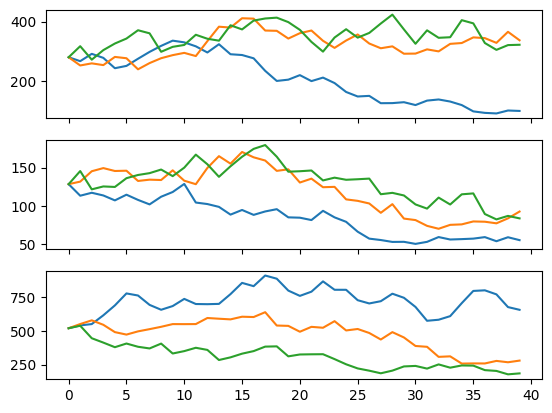

In [40]:
import numpy as np
import matplotlib.pyplot as pl

# returns ndarray with the following dimensions: nProcesses, nPaths, nSteps
def GeneratePaths(spot, process, maturity, nSteps, nPaths, correlation = None):
    np.random.seed(69)
    dt = maturity / nSteps
    
    # case: given correlation matrix, create paths for multiple correlated processes
    if (isinstance(correlation, np.ndarray)):
        nProcesses = process.shape[0]
        result = np.zeros(shape = (nProcesses, nPaths, nSteps))
        
        # loop through number of paths
        for i in range(nPaths):
            # create one set of correlated random variates for n processes
            choleskyMatrix = np.linalg.cholesky(correlation)
            e = np.random.normal(size = (nProcesses, nSteps))            
            paths = np.dot(choleskyMatrix, e)
            # loop through number of steps
            for j in range(nSteps):
                # loop through number of processes
                for k in range(nProcesses):
                    # first path value is always current spot price
                    if(j == 0):
                        result[k, i, j] = paths[k, j] = spot[k]
                    else:
                        # use SDE lambdas (inputs: previous spot, dt, current random variate)
                        result[k, i, j] = paths[k, j] = process[k](paths[k, j - 1], dt, paths[k, j])

    # case: no given correlation matrix, create paths for a single process
    else:
        result = np.zeros(shape = (1, nPaths, nSteps))
        # loop through number of paths
        for i in range(nPaths):
            # create one set of random variates for one process
            path = np.random.normal(size = nSteps)
            # first path value is always current spot price
            result[0, i, 0] = path[0] = spot
            # loop through number of steps
            for j in range(nSteps):
                if(j > 0):
                    # use SDE lambda (inputs: previous spot, dt, current random variate)
                    result[0, i, j] = path[j] = process(path[j - 1], dt, path[j])
    return result

# Geometric Brownian Motion parameters
r = 0.03
v = 0.5

# define lambda for process (inputs: spot, dt, random variate)
BrownianMotion = lambda s, dt, e: s + r * s * dt + v * s * np.sqrt(dt) * e   

# general simulation-related parameters
maturity = 1.0
nPaths = 3
nSteps = 40

# case: one process
# SingleAssetPaths = GeneratePaths(100.0, BrownianMotion, maturity, nSteps, nPaths)
# for i in range(nPaths):
#     pl.plot(SingleAssetPaths[0, i, :])
# pl.show()

# case: two correlated processes
matrix = np.array([[1.0, 0.5, 0], [0.5, 1.0, 0.5], [0, 0.5, 1.0]])
spots = np.array([
    combined_df['ROG_Last_Price'].iloc[-1], 
    combined_df['CFR_Last_Price'].iloc[-1], 
    combined_df['ZURN_Last_Price'].iloc[-1]
    ])
processes = np.array([BrownianMotion, BrownianMotion, BrownianMotion])
MultiAssetPaths = GeneratePaths(spots, processes, maturity, nSteps, nPaths, matrix)
f, subPlots = pl.subplots(processes.shape[0], sharex = True)
for i in range(processes.shape[0]): 
    for j in range(nPaths):
        subPlots[i].plot(MultiAssetPaths[i, j, :])
pl.show()

In [35]:
old_path_rog = combined_df['ROG_Last_Price'].values[:-1]
old_path_cfr = combined_df['CFR_Last_Price'].values[:-1]
old_path_zurn = combined_df['ZURN_Last_Price'].values[:-1]


In [42]:
payoff_list = list()

for idx in range(nPaths):
    print()
    new_path_rog = MultiAssetPaths[0, idx, :].flatten()
    new_path_cfr = MultiAssetPaths[1, idx, :].flatten()
    new_path_zurn = MultiAssetPaths[2, idx, :].flatten()

    path_rog = np.append(old_path_rog, new_path_rog)
    path_cfr = np.append(old_path_cfr, new_path_cfr)
    path_zurn = np.append(old_path_zurn, new_path_zurn)

    simulation_payoff = payoff_func(path_rog=path_rog, path_cfr=path_cfr, path_zurn=path_zurn)
    payoff_list.append(simulation_payoff)

    print()
    print(f'Average payoff: {np.mean(payoff_list)}')
    print(f'Variance payoff: {np.var(payoff_list)}')



Hello
Worst performance: 0.38324707317339857
Barrier event reached: True
Close above initial: True

Average payoff: 470.7470731733986
Variance payoff: 0.0

Hello
Worst performance: 0.6773107685388849
Barrier event reached: True
Close above initial: True

Average payoff: 617.7789208561418
Variance payoff: 21618.364233001397

Hello
Worst performance: 0.44584692160013933
Barrier event reached: True
Close above initial: True

Average payoff: 589.634921104141
Variance payoff: 15996.412266082174
